In [1]:
from utils import conv
from utils import NN2hidden as nn2
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# import os
# # Load images and filenames
# train_images, train_image_filenames = dp.load_images_from_folder_filenames('rev_patching/patch_image')

# # Extract feature maps from images
# feature_maps = [fe.extract(image) for image in train_images]

# # Save feature maps with the same filenames as the original images
# for i, (feature_map, image_filename) in enumerate(zip(feature_maps, train_image_filenames)):
#     image_name = os.path.splitext(image_filename)[0]
#     pil_image = Image.fromarray(feature_map)
#     pil_image.save(f'rev_patching/feature_extract_image/{image_name}.png', format='PNG')

In [3]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/extract_ori'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [4]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

In [5]:
len(feature_images_train)

1769

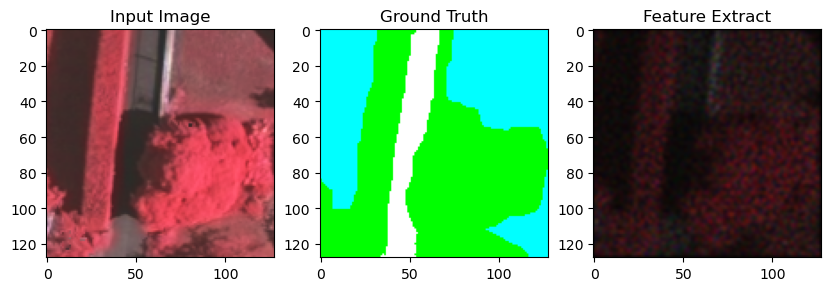

In [27]:
indeks = 5
# Plot the images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(images_load[indeks])
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truths[indeks])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(feature_images_load[indeks])
plt.title('Feature Extract')

plt.show()

In [7]:
# Prepare data
X, y = dp.prepare_data(feature_images_train, image_label_train)

In [9]:
len(X)

3

In [10]:
# Normalize the features
X_normalized = X / 255.0

In [11]:
X_normalized.shape

(3, 28983296)

In [16]:
# Initialize the neural network
input_size = X_normalized.shape[0]
hidden_size1 = 3  # neuron hidden layer 1
hidden_size2 = 2  # neuron hidden layer 2
output_size = 2  # 2 classes: vegetation and non-vegetation
learning_rate = 0.001
num_epochs = 20
toleransi_error = 0.1

# Initialize the neural network with adjusted hidden size
model = nn2.NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Check the shape of weights_hidden_output
print(model.weights_hidden2_output.shape)

(2, 2)


In [18]:
print('Bobot dan bias sebelum training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias sebelum training:
Bobot hidden layer 1:
 [[-0.00516608  0.00478662 -0.01      ]
 [-0.01       -0.00868011  0.01      ]
 [ 0.01       -0.01       -0.01      ]]
Bias hidden layer 1:
 [[0. 0. 0.]]
Bobot hidden layer 2:
 [[-0.01        0.0010035 ]
 [ 0.01       -0.00832615]
 [ 0.00427277  0.00420985]]
Bias hidden layer 2:
 [[0. 0.]]
Bobot output layer:
 [[ 0.01        0.00182789]
 [-0.00813246  0.00126945]]
Bias output layer:
 [[0. 0.]]


In [19]:
# Training loop with batching
batch_size = 128
num_batches = X_normalized.shape[1] // batch_size
losses = []
accuracies = []

threshold = 0.5  # Threshold untuk mengklasifikasikan output

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = X_normalized.shape[1]  # Total sampel dalam satu epoch
    
    for i in range(num_batches):
        # Get batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X_normalized[:, start_idx:end_idx].T
        y_batch = y[:, start_idx:end_idx].T
        
        # Forward pass
        output = model.forward(X_batch)
        
        # Compute loss
        loss = nn2.binary_cross_entropy(y_batch, output)
        epoch_loss += loss
        
        # Compute predictions based on threshold
        predicted_labels = (output >= threshold).astype(int)
        
        # Compute accuracy
        true_labels = y_batch
        correct_predictions += np.sum(predicted_labels == true_labels)
        
        # Backpropagation
        model.backward(X_batch, y_batch, learning_rate)
    
    # Average loss for the epoch
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    
    # Accuracy for the epoch
    accuracy = 1 - epoch_loss
    accuracies.append(accuracy)
    
    # Print loss
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
    
    # Early stopping
    if epoch_loss < toleransi_error:
        print("Training berhenti karena error sudah kurang dari 0.1")
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
        break

Epoch 1, Loss: 0.3343547454784646, Accuracy: 0.6656452545215354
Epoch 2, Loss: 0.27806675252085644, Accuracy: 0.7219332474791436
Epoch 3, Loss: 0.26283350698971963, Accuracy: 0.7371664930102804
Epoch 4, Loss: 0.258795104337298, Accuracy: 0.741204895662702
Epoch 5, Loss: 0.25729276373977134, Accuracy: 0.7427072362602287
Epoch 6, Loss: 0.2564420086886995, Accuracy: 0.7435579913113005
Epoch 7, Loss: 0.25580599457005365, Accuracy: 0.7441940054299463
Epoch 8, Loss: 0.2553662450991317, Accuracy: 0.7446337549008684
Epoch 9, Loss: 0.2551015980171189, Accuracy: 0.744898401982881
Epoch 10, Loss: 0.25499815961909605, Accuracy: 0.745001840380904
Epoch 11, Loss: 0.2549959516933275, Accuracy: 0.7450040483066724
Epoch 12, Loss: 0.2550986342335828, Accuracy: 0.7449013657664172
Epoch 13, Loss: 0.2552793618340218, Accuracy: 0.7447206381659782
Epoch 14, Loss: 0.2553753145672096, Accuracy: 0.7446246854327905
Epoch 15, Loss: 0.2554948936309518, Accuracy: 0.7445051063690482
Epoch 16, Loss: 0.255614981291044

In [20]:
print('Bobot dan bias setelah training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias setelah training:
Bobot hidden layer 1:
 [[ 10.2714834   10.63153753   9.29864547]
 [-13.21074988 -13.68843691 -11.87977969]
 [ -7.98712078  -8.29240238  -7.2009298 ]]
Bias hidden layer 1:
 [[-0.49922822 -0.54231154 -0.35369534]]
Bobot hidden layer 2:
 [[-10.12919518  -8.97211993]
 [-10.54813476  -9.32179909]
 [ -8.95777853  -8.05473233]]
Bias hidden layer 2:
 [[10.89869917  8.69584582]]
Bobot output layer:
 [[-0.09955887  0.09955887]
 [ 1.02196191 -1.02196191]]
Bias output layer:
 [[0.05975596 0.94024404]]


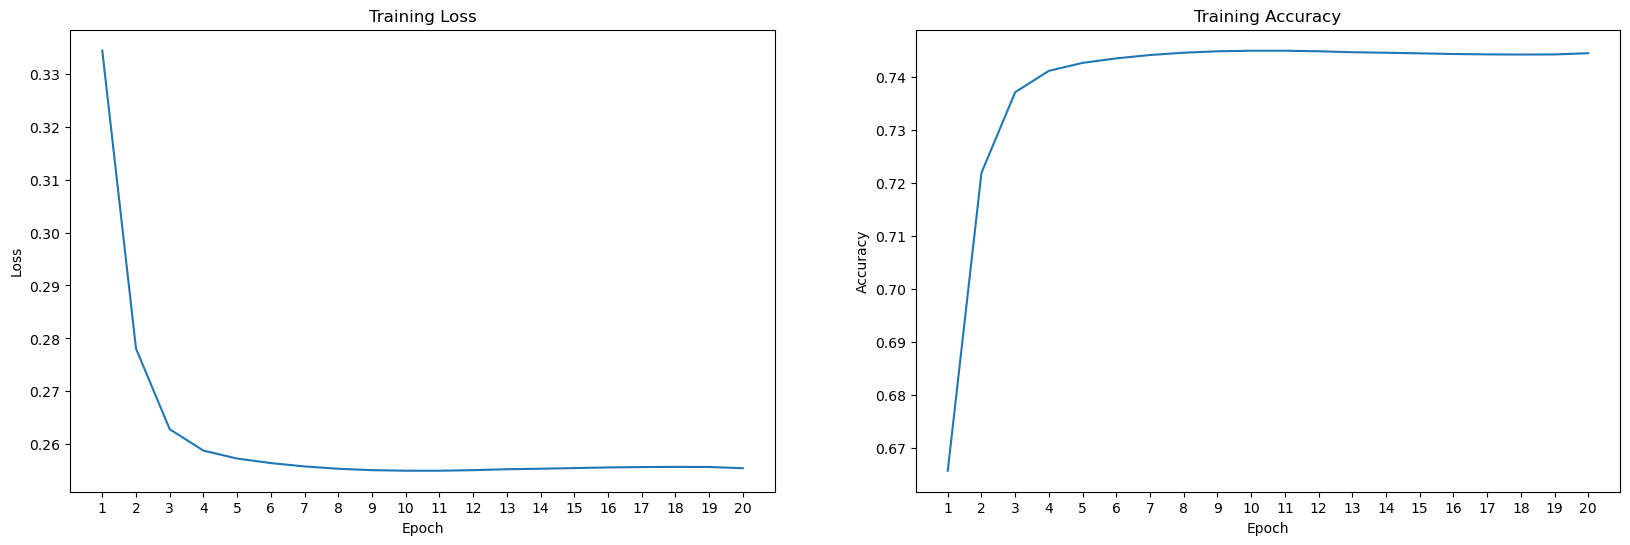

In [21]:
# Plot loss and accuracy
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)  # Menyesuaikan sumbu x
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(losses) + 1))  # Menyesuaikan nilai pada sumbu x

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies)  # Menyesuaikan sumbu x
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Menyesuaikan nilai pada sumbu x

plt.show()

In [22]:
# Save weights to a file
def save_weights(weights_hidden2_output, bias_hidden2_output, weights_hidden1_hidden2, bias_hidden1_hidden2, 
                 weights_input_hidden1, bias_input_hidden1, filename):
    with open(filename, 'wb') as f:
        np.savez(f, weights_hidden2_output=weights_hidden2_output, bias_hidden2_output=bias_hidden2_output,
                 weights_hidden1_hidden2=weights_hidden1_hidden2, bias_hidden1_hidden2=bias_hidden1_hidden2,
                 weights_input_hidden1=weights_input_hidden1, bias_input_hidden1=bias_input_hidden1)

save_weights(model.weights_hidden2_output, model.bias_hidden2_output,
             model.weights_hidden1_hidden2, model.bias_hidden1_hidden2,
             model.weights_input_hidden1, model.bias_input_hidden1,
             "8. Bobot_skenario_8.npz")

In [23]:
print(model.output)

[[0.102938   0.897062  ]
 [0.10408831 0.89591169]
 [0.10492962 0.89507038]
 [0.13656822 0.86343178]
 [0.08929602 0.91070398]
 [0.08646082 0.91353918]
 [0.1236945  0.8763055 ]
 [0.32835837 0.67164163]
 [0.29828455 0.70171545]
 [0.27212275 0.72787725]
 [0.14877477 0.85122523]
 [0.13532498 0.86467502]
 [0.16300461 0.83699539]
 [0.423087   0.576913  ]
 [0.41148455 0.58851545]
 [0.22792688 0.77207312]
 [0.15104987 0.84895013]
 [0.30491815 0.69508185]
 [0.46146337 0.53853663]
 [0.18962191 0.81037809]
 [0.10194398 0.89805602]
 [0.11921005 0.88078995]
 [0.13782673 0.86217327]
 [0.10325813 0.89674187]
 [0.25799086 0.74200914]
 [0.59416881 0.40583119]
 [0.24784408 0.75215592]
 [0.0563314  0.9436686 ]
 [0.0759773  0.9240227 ]
 [0.6875258  0.3124742 ]
 [0.84014276 0.15985724]
 [0.40700473 0.59299527]
 [0.14066941 0.85933059]
 [0.09525352 0.90474648]
 [0.10736861 0.89263139]
 [0.08576428 0.91423572]
 [0.08904607 0.91095393]
 [0.11399007 0.88600993]
 [0.25595241 0.74404759]
 [0.39747458 0.60252542]


before argmax 
 [[0.7237544  0.2762456 ]
 [0.77165828 0.22834172]
 [0.76953724 0.23046276]
 ...
 [0.05975706 0.94024294]
 [0.05975781 0.94024219]
 [0.05975699 0.94024301]]
after argmax 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


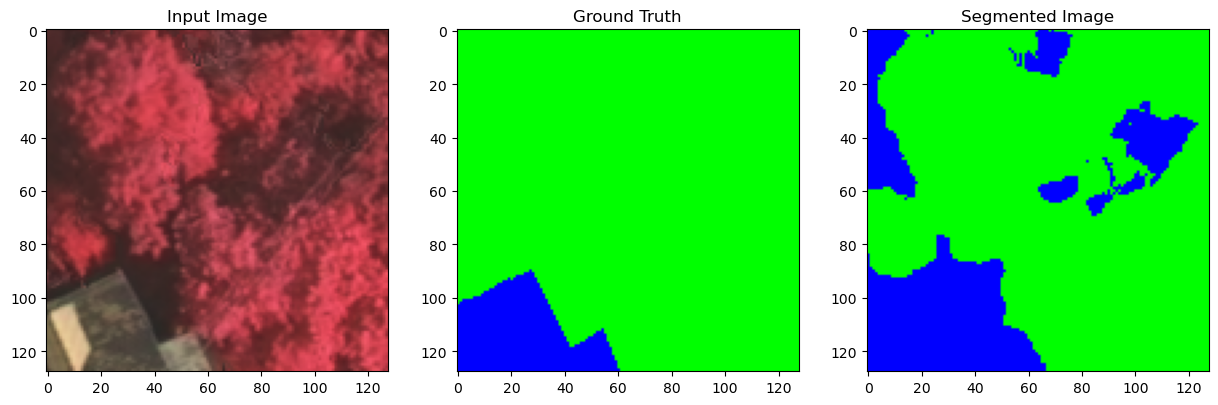

In [112]:
# Define colors for vegetation and non-vegetation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# Visualize segmentation results for one image
indexing = 16
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model.forward(features)
pred_before = predicted_mask
print('before argmax \n',pred_before)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
pred_after= predicted_mask
print('after argmax \n',pred_after[0])
# print(len(predicted_mask))
# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Assign colors based on predicted mask
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.show()

In [24]:
print('nilai prediksi \n', pred_before[50:60])
print('hasil argmax \n', pred_after[2][50:60])

nilai prediksi 
 [[ 0.91309717  0.08292262]
 [ 0.9657361   0.03225555]
 [ 0.99289534  0.00696309]
 [ 1.01450834 -0.01145675]
 [ 1.01434747 -0.0074396 ]
 [ 1.00350878  0.00605556]
 [ 0.99560038  0.01536018]
 [ 0.99342313  0.01787501]
 [ 0.99394047  0.01728584]
 [ 0.99504067  0.01600845]]
hasil argmax 
 [0 0 0 0 0 0 0 0 0 0]


Indeks yang ada warna merah
> 2007
> 2011 - 2013

Keperluan BI indeks analisa : 6, 19, 2012, 3192

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

=-=-=--=-=

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(2, 2, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(2, 2, 4)
plt.imshow(segmented_image)
plt.title('Segmented Image')